In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format
import requests
import json

## Retrieving income and population data
data acquired from bme.ibge.gov.br related to income.

In [2]:
def load_income_91_00(year=1991):
    df = pd.read_csv(
        f'../data/economy/income/income all sources {year} census bme.csv'
        , sep=';'
        , encoding='ANSI'
        , decimal=','
        , thousands='.'
    )

    df.drop(
        labels= [
            'Código do Nível Geográfico'
            , 'Nível Geográfico'
            , 'Item Geográfico'
            , 'Código do Item Temporal'
            , 'Nível Temporal'
            , 'Ordem Geográfica'
            , 'Freqüência'
            , 'Observações']
        , axis=1
        , inplace=True
    )
    
    df.columns = ['Cod', 'Year', 'GrossIncome']
    
    return df

In [3]:
df_income_1991 = load_income_91_00(year=1991)

df_income_2000 = load_income_91_00(year=2000)

df_income_2010 = load_income_91_00(year=2010)

In [4]:
df_income_2000.GrossIncome.sum()

50502003153

In [5]:
# correção dos valores de julho de 2000 e julho de 2010 para 31 de dezembro de 2018
df_income_2000['GrossIncomeDeflated'] = (df_income_2000.GrossIncome * 3.15907400).astype(np.int64)
df_income_2010['GrossIncomeDeflated'] = (df_income_2010.GrossIncome * 1.63968750).astype(np.int64)

In [6]:
df_pop = pd.read_csv('../data/pop/Tabela 200sidra  - pop 1970 a 2010.csv', sep=';', na_values='...')

In [7]:
# carregando dados populacionais
df_pop.rename(columns={'Cód.':'Cod'}, inplace=True)

In [8]:
df_income_2000 = df_income_2000.merge(
    right=df_pop[['Cod', '2000']].dropna().astype(np.int64)
    , on='Cod'
    , how='left'
)

In [9]:
df_income_2010 = df_income_2010.merge(
    right=df_pop[['Cod', '2010']].dropna().astype(np.int64)
    , on='Cod'
    , how='left'
)

In [10]:
df_income_2000.rename(columns={'2000':'pop'}, inplace=True)
df_income_2010.rename(columns={'2010':'pop'}, inplace=True)

In [11]:
pd.concat(objs=[df_income_2000, df_income_2010], axis=0)

Cod  Year  GrossIncome  GrossIncomeDeflated      pop
0     5200050  2000       975424              3081436     4971
1     3100104  2000      1194737              3774262     6446
2     5200100  2000      1923252              6075695    11452
3     3100203  2000      5675485             17929277    22360
4     1500107  2000     12187142             38500083   119152
...       ...   ...          ...                  ...      ...
5560  5222005  2010      8109763             13297477    12548
5561  5222054  2010      4514614              7402556     7371
5562  5222203  2010      1751646              2872152     4735
5563  5222302  2010      1848164              3030411     5145
5564  5300108  2010   4253044160           6973663346  2570160

[11072 rows x 5 columns]

In [12]:
df_territory = pd.read_csv('../data/territory/list_arranjos_pop.csv', sep=';')

In [13]:
df_territory = df_territory[~df_territory['Territory'].str.startswith('Demais')]

In [14]:
df_territory.rename(columns={'Territory':'Metropolitan Area'}, inplace=True)

In [15]:
df_income_2000_2010 = pd.concat(objs=[df_income_2000, df_income_2010], axis=0)

In [16]:
df_income_2000_2010 = df_income_2000_2010.merge(right=df_territory, on='Cod')

In [17]:
df_income_2000_2010 = df_income_2000_2010.groupby(by=['Metropolitan Area', 'Year'], as_index=False).sum()

In [18]:
df_income_2000_2010['Income Per Capita'] = (df_income_2000_2010['GrossIncomeDeflated'] / df_income_2000_2010['pop']).astype(np.int64)

In [19]:
df_income_2000_2010[df_income_2000_2010['Year'] == 2010]

Metropolitan Area  Year        Cod  GrossIncome  GrossIncomeDeflated  \
1     Belo Horizonte  2010   72201369   5029468006           8246755809   
3              Belém  2010    6008125   1446200381           2371316686   
5           Brasília  2010   47008418   4669901655           7657179367   
7           Campinas  2010   28274994   2165419011           3550610480   
9           Curitiba  2010   73979386   3606614703           5913721037   
11     Florianópolis  2010   42089297   1185795747           1944334459   
13         Fortaleza  2010   18444706   2296752742           3765956757   
15           Goiânia  2010   78142510   2174111920           3564864130   
17            Manaus  2010    1302603   1327660607           2176948501   
19      Porto Alegre  2010  125027465   4254620420           6976247905   
21            Recife  2010   39110355   2790532527           4575601295   
23    Rio de Janeiro  2010   69369985  12837485818          21049465017   
25          Salvador  2010   29199223   2953506229           4842827241   
27         São Paulo  2010  130597682  23028791020          37760020758   
29           Vitória  2010   19224127   1613175467           2645103646   

         pop  Income Per Capita  
1    4744706               1738  
3    2025276               1170  
5    3360552               2278  
7    1874442               1894  
9    3054076               1936  
11    883808               2199  
13   3327021               1131  
15   2078399               1715  
17   1802014               1208  
19   3701482               1884  
21   3741904               1222  
23  11946398               1761  
25   3482615               1390  
27  19629394               1923  
29   1582418               1671

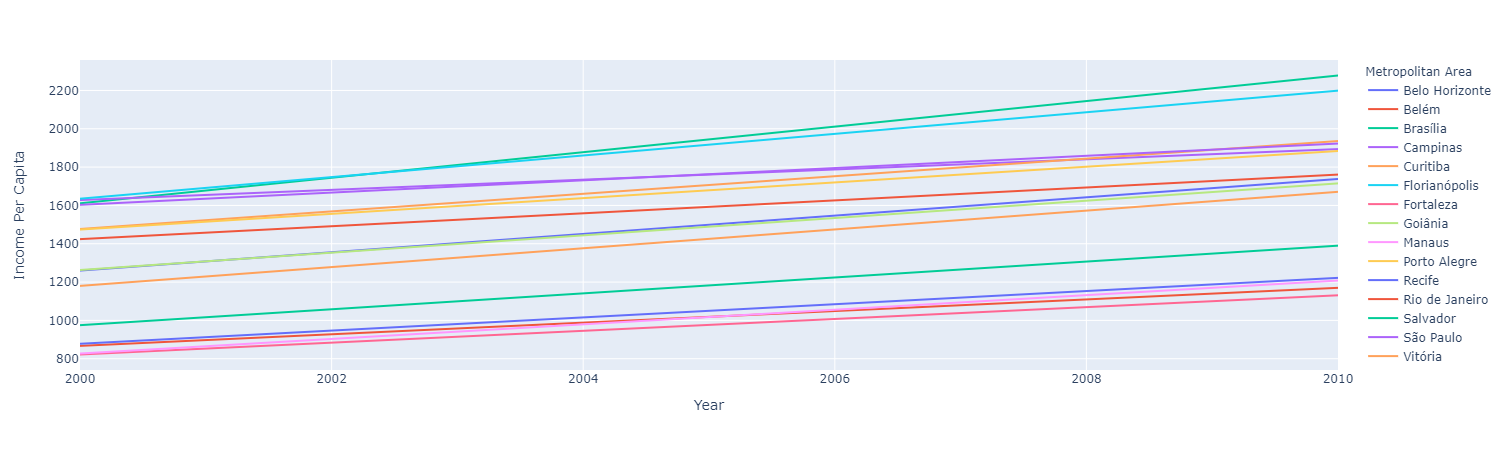

In [20]:
fig = px.line(
    data_frame=df_income_2000_2010
    , x='Year'
    , y='Income Per Capita'
    , color='Metropolitan Area'

)
fig.show()

In [21]:
dict_groups = {
    'Belo Horizonte':'Group B'
    ,'Belém':'Group C'
    ,'Brasília': 'Group A'
    ,'Campinas': 'Group B'
    ,'Curitiba': 'Group B'
    ,'Florianópolis': 'Group A'
    ,'Fortaleza':'Group C'
    ,'Goiânia':'Group B'
    ,'Manaus': 'Group C'
    ,'Porto Alegre': 'Group B'
    ,'Recife':'Group C'
    ,'Rio de Janeiro':'Group B'
    ,'Salvador':'Group C'
    ,'São Paulo': 'Group B'
    ,'Vitória':'Group B'
}

In [22]:
for i, scatter in enumerate(fig.data):
    key = fig.data[i].legendgroup
    fig.data[i].legendgroup = dict_groups[key]

In [23]:
dict_dash = {
    'Belo Horizonte':'dot'
    ,'Belém':'longdashdot'
    ,'Brasília': 'solid'
    ,'Campinas': 'dot'
    ,'Curitiba': 'dot'
    ,'Florianópolis': 'solid'
    ,'Fortaleza':'longdashdot'
    ,'Goiânia':'dot'
    ,'Manaus': 'longdashdot'
    ,'Porto Alegre': 'dot'
    ,'Recife':'longdashdot'
    ,'Rio de Janeiro':'dot'
    ,'Salvador':'longdashdot'
    ,'São Paulo': 'dot'
    ,'Vitória':'dot'
}

In [24]:
fig.data[0].line.dash

'solid'

In [25]:
for i, key in enumerate(dict_dash.keys()):
    fig.data[i].line.dash = dict_dash[key]

In [26]:
fig.layout.legend.tracegroupgap = 15

In [27]:
fig.layout.legend.traceorder = "reversed+grouped"

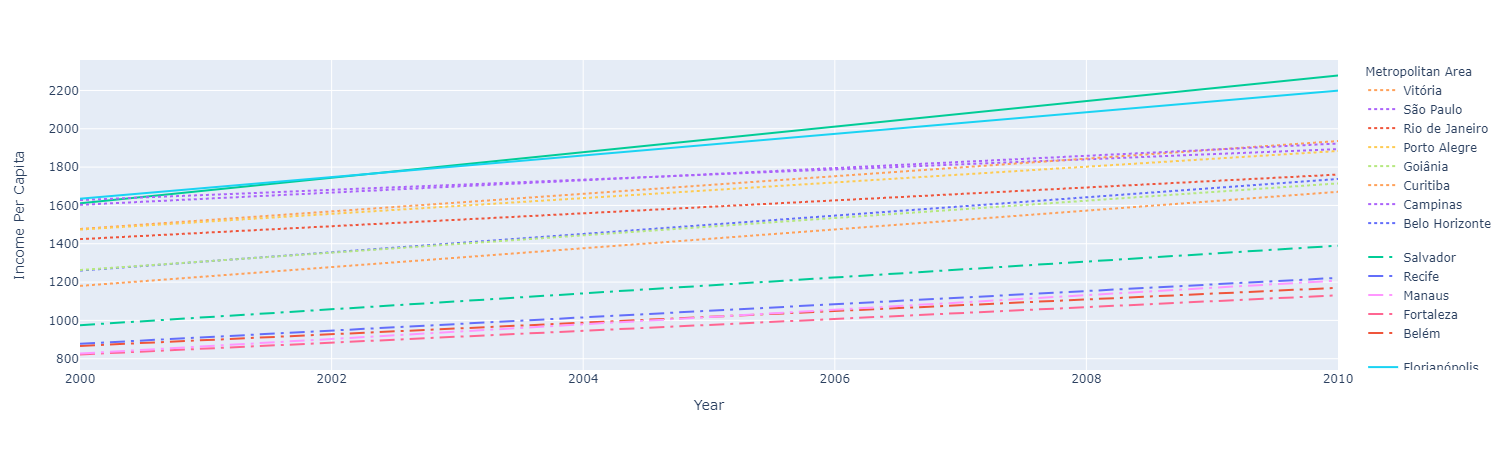

In [28]:
fig

## GDP

In [29]:
df_gdp = pd.read_csv('../data/economy/gdp/gdp_2002_2018_base18.csv', sep=';')

In [30]:
df_gdp = df_territory.merge(df_gdp, how='left', on='Cod')

In [31]:
df_gdp.drop(labels=['Cod', 'Municipio'], axis=1, inplace=True)

In [32]:
df_gdp.iloc[:,1:] = df_gdp.iloc[:,1:].astype(np.int64)

In [33]:
df_gdp = df_gdp.melt(df_gdp.columns[0], var_name='Year', value_name='GDP R$1000')

In [34]:
df_gdp = df_gdp.groupby(by=['Metropolitan Area', 'Year'], as_index=False).sum()

In [35]:
df_gdp

Metropolitan Area  Year  GDP R$1000
0      Belo Horizonte  2002   137470936
1      Belo Horizonte  2003   139053813
2      Belo Horizonte  2004   146912914
3      Belo Horizonte  2005   153592794
4      Belo Horizonte  2006   166315348
..                ...   ...         ...
250           Vitória  2014    78801206
251           Vitória  2015    72966685
252           Vitória  2016    66029724
253           Vitória  2017    63086570
254           Vitória  2018    74352397

[255 rows x 3 columns]

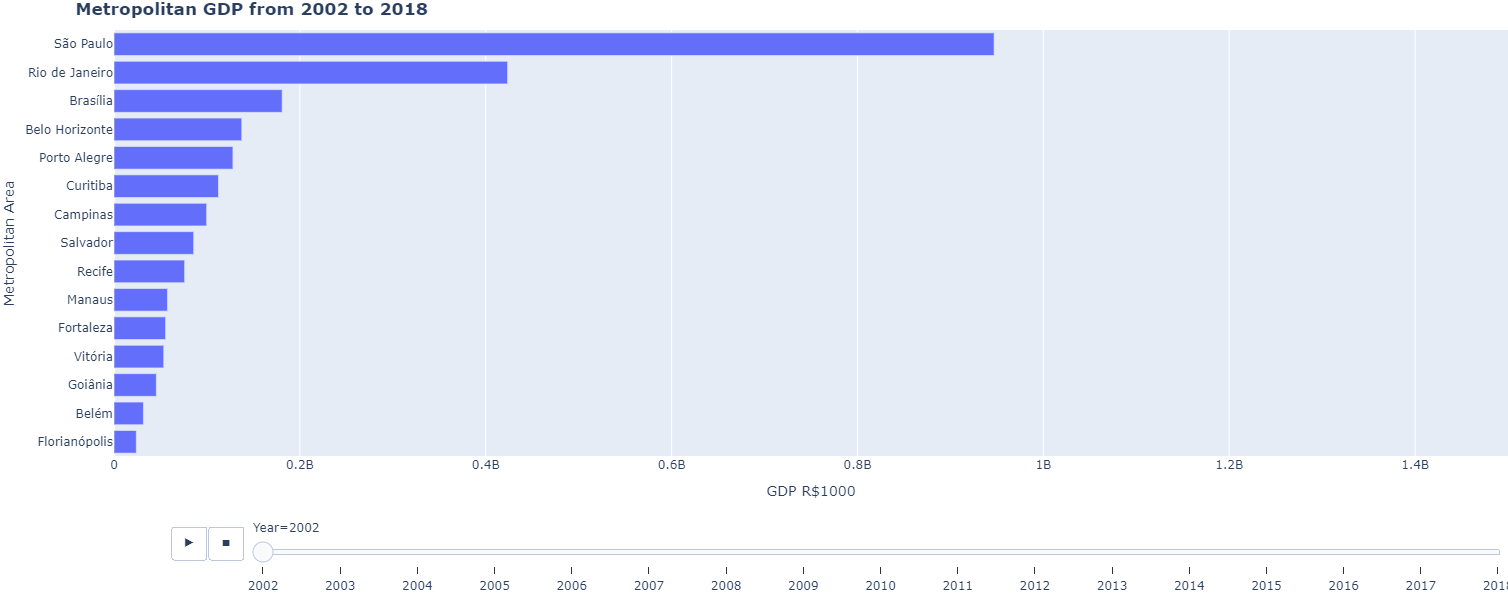

In [36]:
fig = px.bar(
    data_frame=df_gdp
    , y = 'Metropolitan Area'
    , x='GDP R$1000'
    , orientation='h'
    , animation_frame='Year'
    , range_x = [0,1.5e9]
    , title = '<b>Metropolitan GDP from 2002 to 2018<b>'
    , height=600 
    , width = 1380
)

fig.update_layout(yaxis={'categoryorder':"sum ascending"})
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000 
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))

In [37]:
pio.write_json(fig, '../data/economy/gdp/px_bar_gdp_02_18_dynamic.json')

## GDP 1970 A 1996

In [38]:
df_gdp_1970_1996 = pd.read_csv('../data/economy/gdp/gdp_1970_1996_base10.csv', sep=';')

In [39]:
df_gdp_1970_1996.iloc[:,3:].sum()

1975   1,203,270,237.50
1980   1,743,651,216.19
1985   1,958,296,742.61
1996   2,130,635,355.19
dtype: float64

In [40]:
df_gdp_1970_1996.rename(columns={'Código':'Cod'}, inplace=True)

In [41]:
df_gdp_1970_1996.fillna(0, inplace=True)

In [42]:
df_gdp_1970_1996['1996'].max()

316172787.1

In [43]:
df_gdp_1970_1996

Cod       Município      1970      1975       1980       1985  \
0     1200013      Acrelândia      0.00      0.00       0.00       0.00   
1     1200054    Assis Brasil      0.00      0.00   5,137.53   7,837.33   
2     1200104       Brasiléia 29,836.81 51,756.40  58,906.27 130,550.84   
3     1200138          Bujari      0.00      0.00       0.00       0.00   
4     1200179        Capixaba      0.00      0.00       0.00       0.00   
...       ...             ...       ...       ...        ...        ...   
5591  1721208  Tocantinópolis 34,686.17 44,908.96  90,854.45  69,650.59   
5592  1721257        Tupirama      0.00      0.00       0.00       0.00   
5593  1721307      Tupiratins      0.00      0.00       0.00       0.00   
5594  1722081    Wanderlândia      0.00      0.00       0.00   8,966.59   
5595  1722107         Xambioá 12,294.04 23,806.97 105,511.55  73,208.98   

           1996  
0     26,087.87  
1     16,125.94  
2    113,246.63  
3     43,815.46  
4     30,908.23  
...         ...  
5591  47,245.24  
5592       0.00  
5593   3,590.03  
5594  37,097.17  
5595  48,441.39  

[5596 rows x 7 columns]

In [44]:
df_gdp_1970_1996.iloc[:,3:].sum()

1975   1,203,270,237.50
1980   1,743,651,216.19
1985   1,958,296,742.61
1996   2,130,635,355.19
dtype: float64

In [45]:
# deflating according to implicit deflator of gdp IPEA
df_gdp_1970_1996.iloc[:,3:] = df_gdp_1970_1996.iloc[:,3:] * 1.70763883589303

In [46]:
df_gdp_1970_1996['1996'].max()

539908930.1044989

In [47]:
df_gdp_1970_1996 = df_gdp_1970_1996.merge(df_territory, on='Cod', how='inner')

In [48]:
df_gdp_1970_1996['1996'].max()

539908930.1044989

In [49]:
df_gdp_1970_1996.drop(labels=['Cod', 'Município'], axis=1, inplace=True)

In [50]:
df_gdp_1970_1996[df_gdp_1970_1996['1996'] == df_gdp_1970_1996['1996'].max()]

1970           1975           1980           1985  \
207 137,425,142.60 378,693,659.99 465,030,036.64 436,622,618.99   

              1996 Metropolitan Area  
207 539,908,930.10         São Paulo

In [51]:
df_gdp_1970_1996 = df_gdp_1970_1996.melt(id_vars=['Metropolitan Area'], var_name='Year', value_name='GDP R$1000')

In [52]:
df_gdp_1970_1996[df_gdp_1970_1996['GDP R$1000'] == df_gdp_1970_1996['GDP R$1000'].max()]

Metropolitan Area  Year     GDP R$1000
1063         São Paulo  1996 539,908,930.10

In [53]:
df_gdp_1970_1996 = df_gdp_1970_1996.groupby(by=['Metropolitan Area', 'Year'], as_index=False).sum()

In [54]:
df_gdp_1970_1996

Metropolitan Area  Year     GDP R$1000
0     Belo Horizonte  1970  18,602,938.05
1     Belo Horizonte  1975  61,494,173.25
2     Belo Horizonte  1980  97,733,787.99
3     Belo Horizonte  1985 102,179,753.04
4     Belo Horizonte  1996 140,655,239.04
..               ...   ...            ...
70           Vitória  1970   4,449,609.65
71           Vitória  1975  10,505,897.17
72           Vitória  1980  23,943,120.13
73           Vitória  1985  29,274,617.73
74           Vitória  1996  39,825,557.09

[75 rows x 3 columns]

In [55]:
df_gdp_70_18 = pd.concat(objs=[df_gdp, df_gdp_1970_1996], axis=0)

In [56]:
df_gdp_70_18[df_gdp_70_18['Metropolitan Area'] == 'São Paulo']

Metropolitan Area  Year       GDP R$1000
221         São Paulo  2002   947,059,117.00
222         São Paulo  2003   934,669,160.00
223         São Paulo  2004   950,586,630.00
224         São Paulo  2005 1,021,156,398.00
225         São Paulo  2006 1,063,267,421.00
226         São Paulo  2007 1,135,267,200.00
227         São Paulo  2008 1,162,417,293.00
228         São Paulo  2009 1,172,089,453.00
229         São Paulo  2010 1,249,136,397.00
230         São Paulo  2011 1,282,829,400.00
231         São Paulo  2012 1,273,722,474.00
232         São Paulo  2013 1,292,941,919.00
233         São Paulo  2014 1,286,027,366.00
234         São Paulo  2015 1,236,782,652.00
235         São Paulo  2016 1,197,128,599.00
236         São Paulo  2017 1,190,494,213.00
237         São Paulo  2018 1,179,573,402.00
65          São Paulo  1970   184,527,073.74
66          São Paulo  1975   525,161,568.03
67          São Paulo  1980   678,658,930.10
68          São Paulo  1985   663,263,324.29
69          São Paulo  1996   754,770,273.68

In [57]:
df_gdp_70_18.loc[:,'Year'] = df_gdp_70_18.loc[:,'Year'].astype(np.int32)

In [58]:
df_gdp_70_18.sort_values(by=['Year', 'Metropolitan Area'], inplace=True)

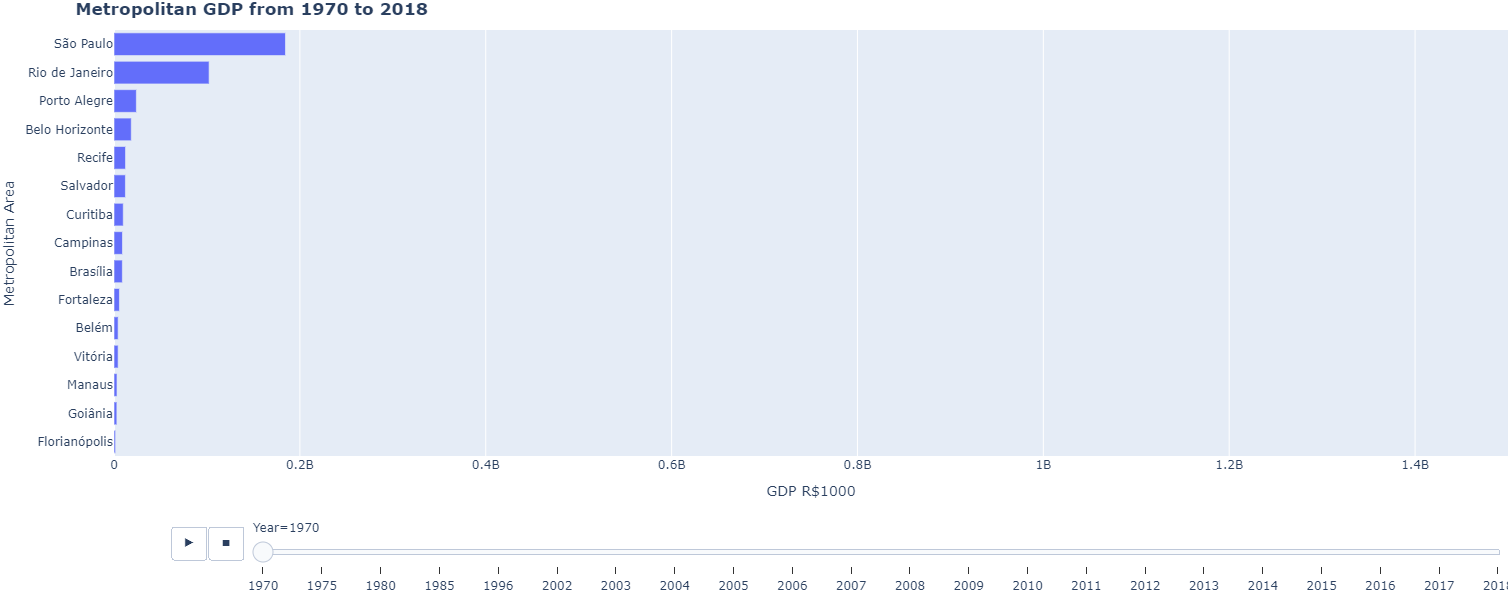

In [59]:
fig_70_18 = px.bar(
    data_frame=df_gdp_70_18
    , y = 'Metropolitan Area'
    , x='GDP R$1000'
    , orientation='h'
    , animation_frame='Year'
    , range_x = [0,1.5e9]
    , title = '<b>Metropolitan GDP from 1970 to 2018<b>'
    , height=600 
    , width = 1380
)

fig_70_18.update_layout(yaxis={'categoryorder':"sum ascending"})
fig_70_18.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000 
fig_70_18.update_layout(margin=dict(l=0, r=0, b=0, t=30))

In [60]:
pio.write_json(fig_70_18, '../data/economy/gdp/px_bar_gdp_02_18_dynamic.json')

## Retrieving Population Data

In [61]:
df_pop = pd.read_csv('../data/pop/Tabela 200sidra  - pop 1970 a 2010.csv', sep=';', na_values='...')

In [62]:
df_pop.columns = ['Cod', 'Municipality', '1970', '1980', '1991', '2000', '2010', '2018']

In [63]:
#df_pop.drop(labels=['Municipio'], axis=1, inplace=True)

In [64]:
df_pop = df_pop.melt(id_vars=['Cod', 'Municipality'], var_name='Year', value_name='Pop')

In [65]:
df_pop = df_pop.dropna()

In [66]:
df_pop.loc[:,'Pop'] = df_pop.loc[:,'Pop'].astype(np.int64)

In [67]:
df_pop = df_pop.merge(right=df_territory, how='right', on='Cod')

In [68]:
df_pop.drop('Cod', axis=1).groupby(['Metropolitan Area', 'Year'], as_index=False).sum()

Metropolitan Area  Year      Pop
0     Belo Horizonte  1970  1646553
1     Belo Horizonte  1980  2590888
2     Belo Horizonte  1991  3409027
3     Belo Horizonte  2000  4235210
4     Belo Horizonte  2010  4744706
..               ...   ...      ...
85           Vitória  1980   715459
86           Vitória  1991  1075123
87           Vitória  2000  1350196
88           Vitória  2010  1582418
89           Vitória  2018  1828691

[90 rows x 3 columns]

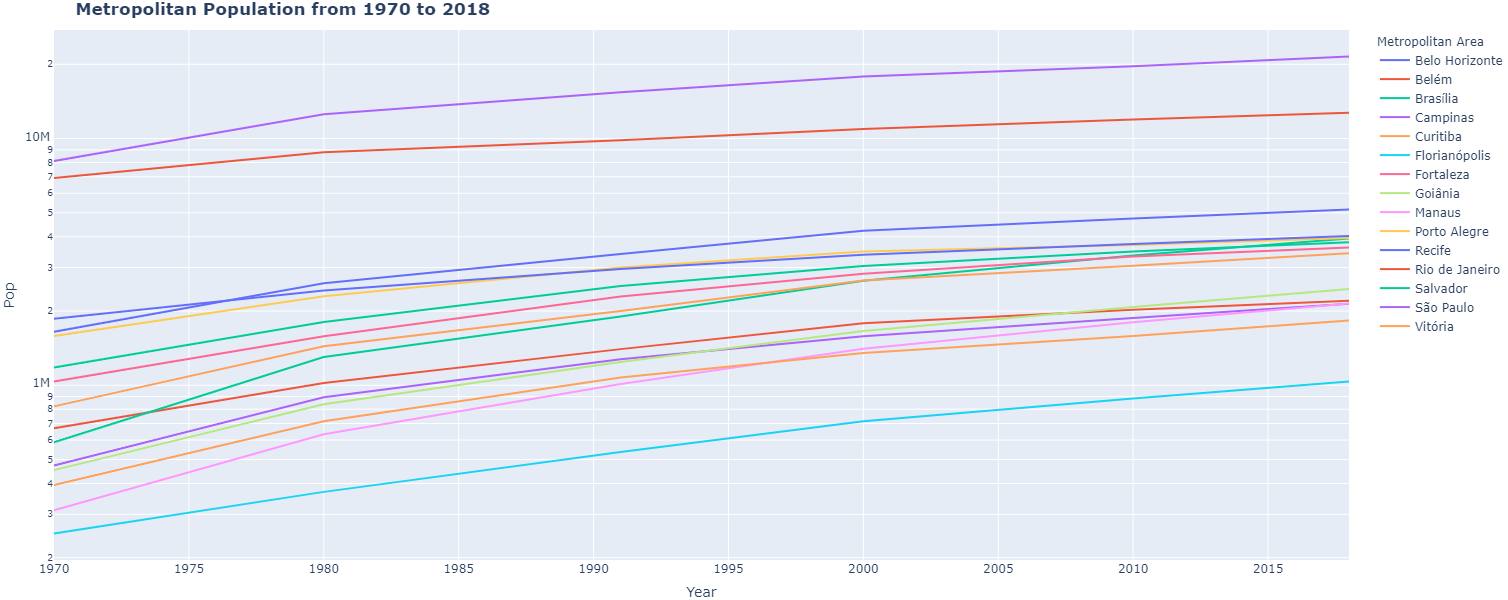

In [69]:
fig_pop_line = px.line(
    data_frame=df_pop.drop('Cod', axis=1).groupby(['Metropolitan Area', 'Year'], as_index=False).sum()
    , x='Year'
    , y='Pop'
    , color='Metropolitan Area'
    , log_y=True
    , title = '<b>Metropolitan Population from 1970 to 2018<b>'
    , height=600 
    , width = 1380
)
fig_pop_line.update_layout(margin=dict(l=0, r=0, b=0, t=30))

In [70]:
dict_groups = {
    'Belo Horizonte':'Group B'
    ,'Belém':'Group C'
    ,'Brasília': 'Group B'
    ,'Campinas': 'Group C'
    ,'Curitiba': 'Group B'
    ,'Florianópolis': 'Group D'
    ,'Fortaleza':'Group B'
    ,'Goiânia':'Group C'
    ,'Manaus': 'Group C'
    ,'Porto Alegre': 'Group B'
    ,'Recife':'Group B'
    ,'Rio de Janeiro':'Group A'
    ,'Salvador':'Group B'
    ,'São Paulo': 'Group A'
    ,'Vitória':'Group C'
}

In [71]:
for i, scatter in enumerate(fig_pop_line.data):
    key = scatter.legendgroup
    fig_pop_line.data[i].legendgroup = dict_groups[key]

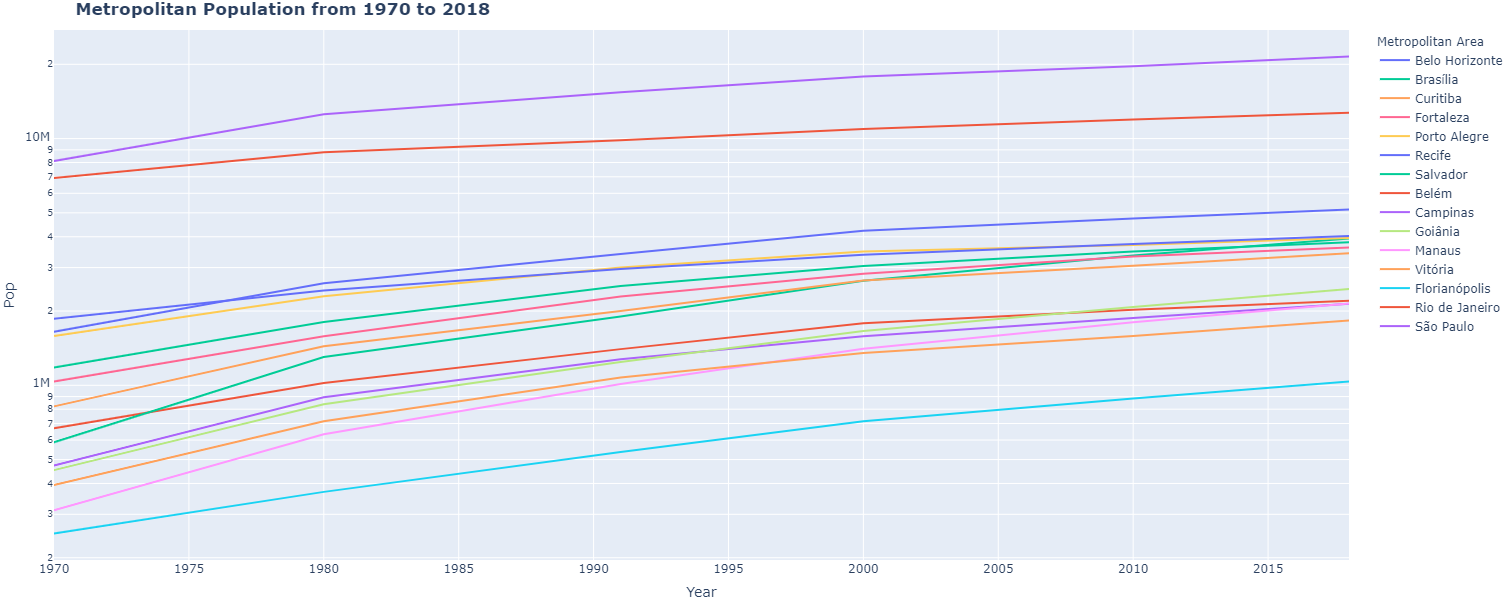

In [72]:
fig_pop_line

In [73]:
dict_dash = {
    'Belo Horizonte':'dash'
    ,'Belém':'longdashdot'
    ,'Brasília': 'dash'
    ,'Campinas': 'longdashdot'
    ,'Curitiba':'dash'
    ,'Florianópolis': 'solid'
    ,'Fortaleza':'dash'
    ,'Goiânia':'longdashdot'
    ,'Manaus': 'longdashdot'
    ,'Porto Alegre':'dash'
    ,'Recife':'dash'
    ,'Rio de Janeiro':'dot'
    ,'Salvador':'dash'
    ,'São Paulo': 'dot'
    ,'Vitória':'longdashdot'
}

In [74]:
for i, key in enumerate(dict_dash.keys()):
    fig_pop_line.data[i].line.dash = dict_dash[key]

In [75]:
fig_pop_line.layout.legend.tracegroupgap = 15

In [76]:
fig_pop_line.layout.legend.traceorder = "grouped"

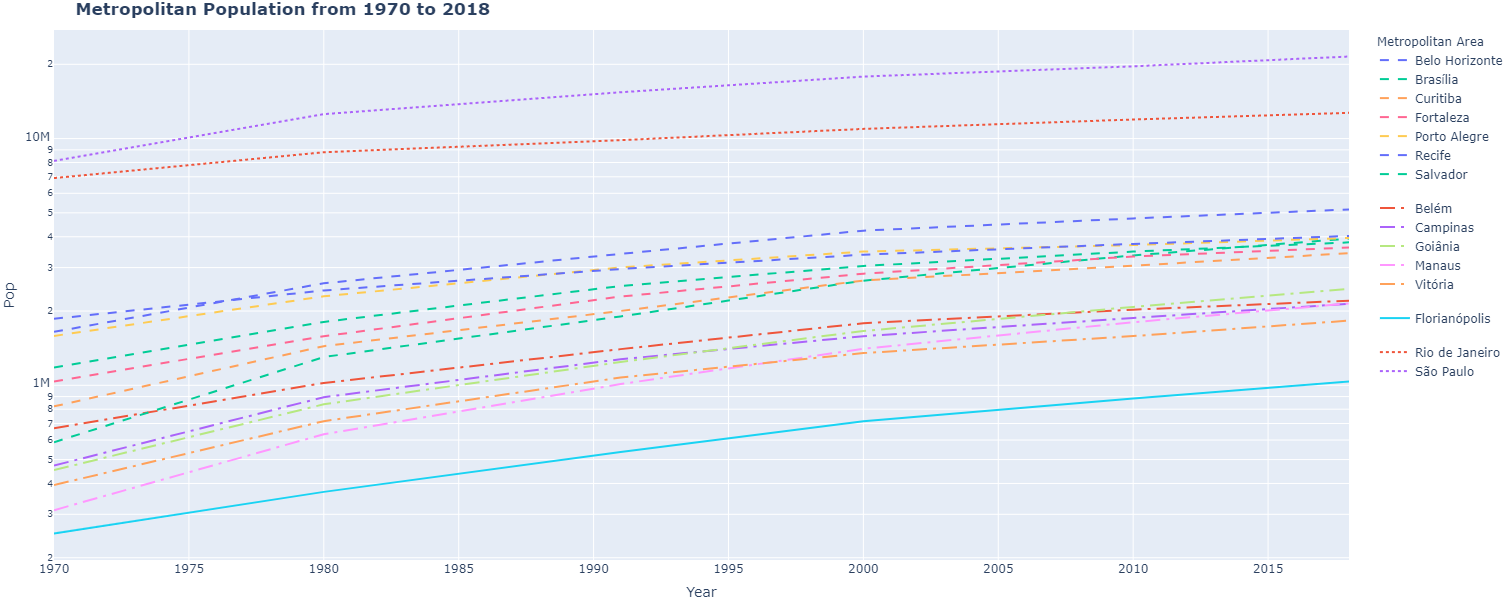

In [77]:
fig_pop_line

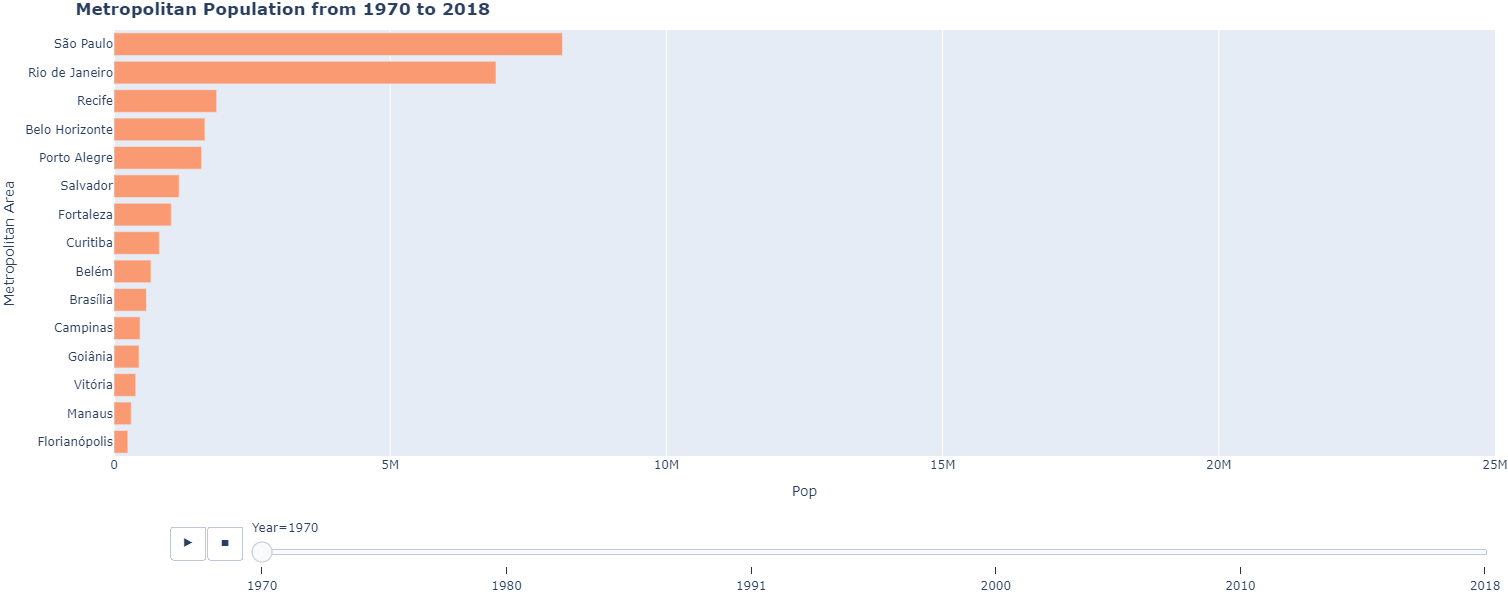

In [78]:
fig_pop = px.bar(
    data_frame=df_pop.drop('Cod', axis=1).groupby(['Metropolitan Area', 'Year'], as_index=False).sum().sort_values(by=['Year', 'Metropolitan Area'])
    , y='Metropolitan Area'
    , x='Pop'
    , animation_frame='Year'
    , orientation='h'
    , range_x = [0,2.5e7]
    , title = '<b>Metropolitan Population from 1970 to 2018<b>'
    , height=600 
    , width = 1380
    , color_discrete_sequence=['#FA9A73']
#    , hover_name='Metropolitan Area'
    , hover_data=['Year', 'Pop']
)
fig_pop.update_layout(yaxis={'categoryorder':"sum ascending"})
fig_pop.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000 
fig_pop.update_layout(margin=dict(l=0, r=0, b=0, t=30))

In [79]:
pio.write_json(fig_pop, '../data/pop/px_bar_pop_70_18_dynamic.json')

## Retrieving GDP per capita

In [80]:
df_pop = df_pop.drop('Cod', axis=1).groupby(['Metropolitan Area', 'Year'], as_index=False).sum().sort_values(by=['Year', 'Metropolitan Area'])

In [81]:
df_pop['Year'] = df_pop.Year.astype(np.int32)

In [82]:
df_pop.merge(df_gdp_70_18, how='left', on=['Metropolitan Area', 'Year'])

Metropolitan Area  Year       Pop       GDP R$1000
0     Belo Horizonte  1970   1646553    18,602,938.05
1              Belém  1970    669768     4,460,086.76
2           Brasília  1970    587652     9,003,962.68
3           Campinas  1970    472829     9,120,531.65
4           Curitiba  1970    821233     9,970,486.81
..               ...   ...       ...              ...
85            Recife  2018   4031485   107,509,937.00
86    Rio de Janeiro  2018  12712762   565,696,625.00
87          Salvador  2018   3795668   117,996,716.00
88         São Paulo  2018  21510595 1,179,573,402.00
89           Vitória  2018   1828691    74,352,397.00

[90 rows x 4 columns]

In [83]:
df_pop_estimated = pd.read_csv('../data/pop/pop_1970_2018.csv', sep=';')

In [84]:
df_pop_estimated = df_territory.merge(df_pop_estimated, on='Cod', how='left')

In [85]:
df_pop_estimated.drop(labels=['Cod', 'Município'], axis=1, inplace=True)

In [86]:
df_temp = df_pop_estimated.groupby(by=['Metropolitan Area'], as_index=False).sum().melt(id_vars=['Metropolitan Area'], var_name='Year', value_name='Pop')

In [87]:
df_temp['Year'] = df_temp.Year.astype(np.int32)

In [88]:
df_gdp_70_18 = df_gdp_70_18.merge(right=df_temp, how='inner', left_on=['Metropolitan Area', 'Year'], right_on=['Metropolitan Area', 'Year'])

In [89]:
df_gdp_70_18['GDP per capita'] = (df_gdp_70_18['GDP R$1000'] / df_gdp_70_18.Pop * 1000).astype(np.int32)

In [90]:
df_gdp_70_18.Year.unique()

array([1970, 1980, 1996, 2002, 2003, 2004, 2005, 2006, 2008, 2009, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [91]:
df_gdp_70_18[df_gdp_70_18.Year > 1996]

Metropolitan Area  Year       GDP R$1000       Pop  GDP per capita
45     Belo Horizonte  2002   137,470,936.00   4406819           31195
46              Belém  2002    31,674,817.00   1866561           16969
47           Brasília  2002   180,989,175.00   2813306           64333
48           Campinas  2002    99,720,336.00   1646574           60562
49           Curitiba  2002   112,477,090.00   2797437           40207
..                ...   ...              ...       ...             ...
265            Recife  2018   107,509,937.00   4031485           26667
266    Rio de Janeiro  2018   565,696,625.00  12712762           44498
267          Salvador  2018   117,996,716.00   3795668           31087
268         São Paulo  2018 1,179,573,402.00  21510595           54836
269           Vitória  2018    74,352,397.00   1828691           40658

[225 rows x 5 columns]

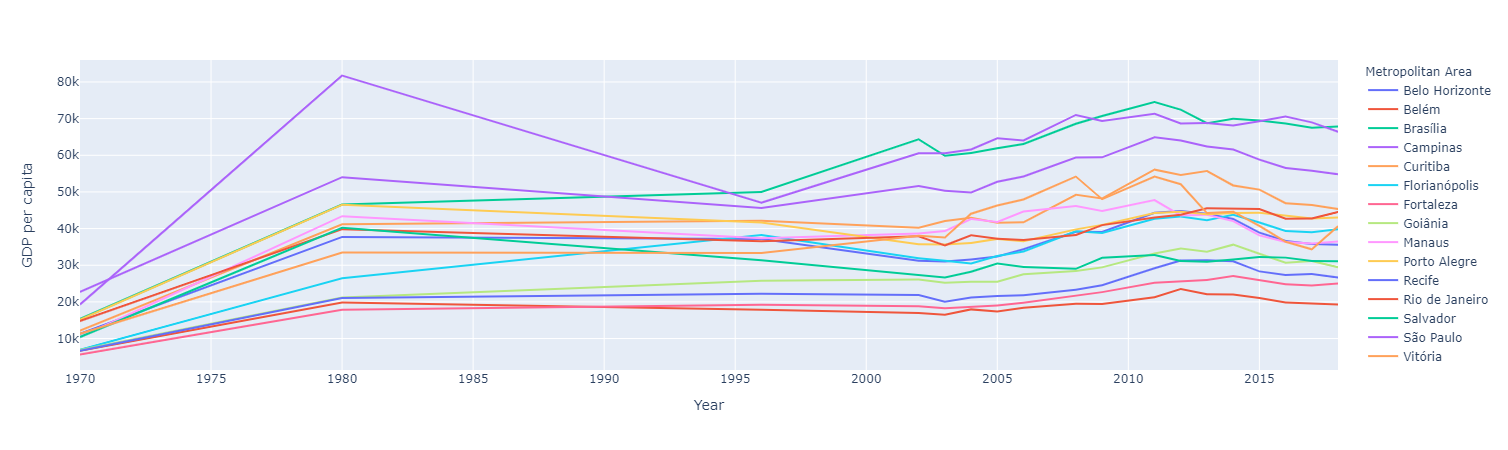

In [92]:
px.line(
    data_frame=df_gdp_70_18
    , x='Year'
    , y='GDP per capita'
    , color='Metropolitan Area'
#    , log_y=True
)


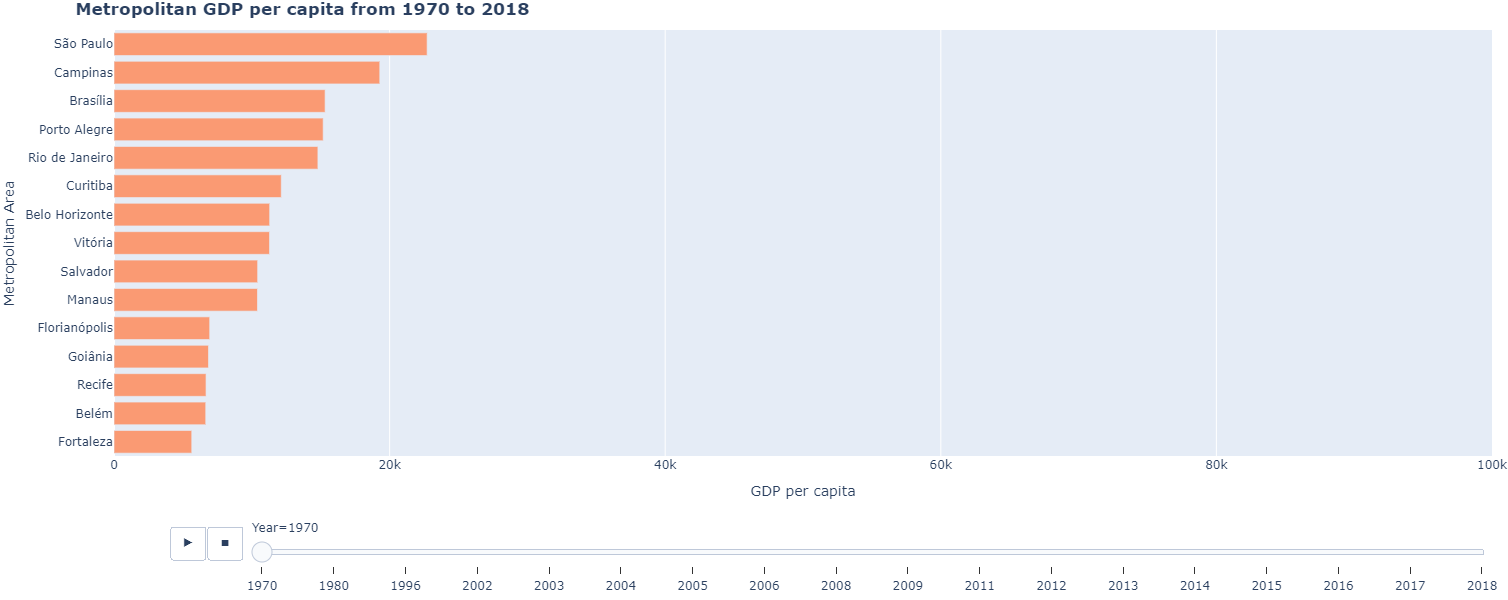

In [93]:
fig_gdp_percapita = px.bar(
#    data_frame=df_gdp_70_18[df_gdp_70_18.Year > 1996]
    data_frame=df_gdp_70_18    
    , y='Metropolitan Area'
    , x='GDP per capita'
    , animation_frame='Year'
    , orientation='h'
    , range_x = [0, 10.0e4]
    , title = '<b>Metropolitan GDP per capita from 1970 to 2018<b>'
    , height=600 
    , width = 1380
    , color_discrete_sequence=['#FA9A73']
#    , hover_name='Metropolitan Area'
#    , hover_data=['Year', 'Pop']
)
fig_gdp_percapita.update_layout(yaxis={'categoryorder':"sum ascending"})
fig_gdp_percapita.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000 
fig_gdp_percapita.update_layout(margin=dict(l=0, r=0, b=0, t=30))

In [94]:
pio.write_json(fig_gdp_percapita, '../data/economy/gdp/px_bar_gdppercapita_02_18_dynamic.json')

## Retomando dados corretos de Renda e Renda Per Capita

In [95]:
df_income_70_00 = pd.read_csv('../data/economy/income/total_income_ipea_1970_2000.csv', sep=';')

In [96]:
df_income_70_00.iloc[:,2:] = df_income_70_00.iloc[:,2:].fillna(0)

In [97]:
# correcting data, considering it was 1,25% less then IBGE's in 2000 (multiplying for 1000, considering they simplified the currency)
df_income_70_00.iloc[:,2:] = df_income_70_00.iloc[:,2:] * 1.01248 * 1000

In [98]:
# deflating values from july/2000 to december/2018 (IPCA)
df_income_70_00.iloc[:,2:] = (df_income_70_00.iloc[:,2:] * 3.15907400).astype(np.int64)

In [99]:
def load_income_91_00(year=1991):
    df = pd.read_csv(
        f'../data/economy/income/income all sources {year} census bme.csv'
        , sep=';'
        , encoding='ANSI'
        , decimal=','
        , thousands='.'
    )

    df.drop(
        labels= [
            'Código do Nível Geográfico'
            , 'Nível Geográfico'
            , 'Item Geográfico'
            , 'Código do Item Temporal'
            , 'Nível Temporal'
            , 'Ordem Geográfica'
            , 'Freqüência'
            , 'Observações']
        , axis=1
        , inplace=True
    )
    
    df.columns = ['Cod', 'Year', 'GrossIncome']
    
    return df

In [100]:
df_income_2010 = load_income_91_00(year=2010)

In [101]:
# correção dos valores de julho de 2000 e julho de 2010 para 31 de dezembro de 2018
df_income_2010['GrossIncome'] = (df_income_2010.GrossIncome * 1.63968750).astype(np.int64)

In [102]:
df_income_70_10 = df_income_70_00.merge(
    right=df_income_2010.rename(columns={'GrossIncome': '2010'}).drop(labels='Year', axis=1)
    ,on='Cod'
    ,how='left' 
)

In [103]:
df_income_70_10['2010'] = df_income_70_10['2010'].fillna(0).astype(np.int64)

In [104]:
df_income_70_10 = df_territory.merge(
    right=df_income_70_10
    , on='Cod'
    , how='left'
)

In [105]:
df_income_70_10.rename(columns={'Territory': 'Metropolitan Area'}, inplace=True)

In [106]:
df_income_70_10 = df_income_70_10[~df_income_70_10['Metropolitan Area'].str.startswith('Demais')]

In [107]:
df_income_70_10 = df_income_70_10.drop(labels=['Cod', 'Município'], axis=1).melt(id_vars=['Metropolitan Area'], var_name='Year', value_name='Income')

In [108]:
df_income_70_10 = df_income_70_10.groupby(
    by=['Metropolitan Area', 'Year']
    , as_index=False
).sum()

In [109]:
df_income_70_10['Year'] = df_income_70_10['Year'].astype(np.int32)

In [110]:
df_income_70_10_percapita = df_income_70_10.merge(
    right=df_pop
    , left_on=['Metropolitan Area', 'Year']
    , right_on=['Metropolitan Area', 'Year']
    , how='left'
)

In [111]:
df_income_70_10_percapita['Montly Per Capita Income'] = (df_income_70_10_percapita['Income'] / df_income_70_10_percapita['Pop']).astype(np.int64)

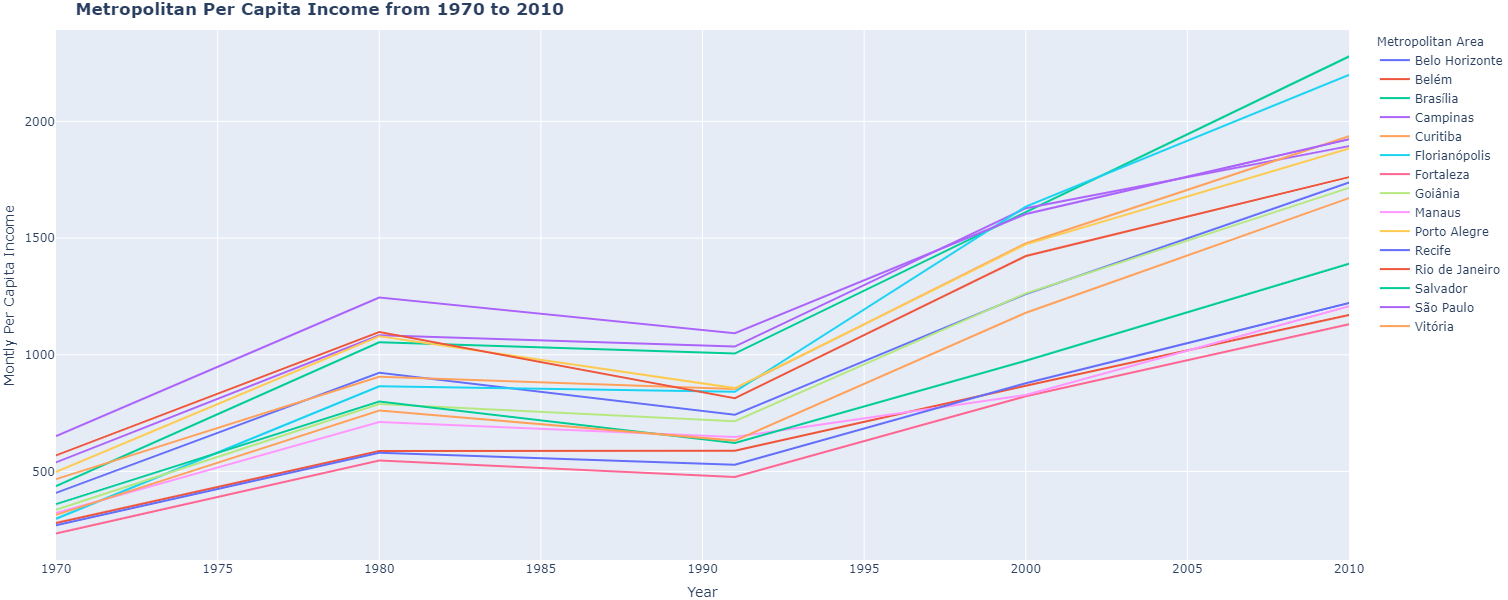

In [112]:
fig_percap_income = px.line(
    data_frame=df_income_70_10_percapita
    , x='Year'
    , y='Montly Per Capita Income'
    , color='Metropolitan Area'
#    , log_y=True
    , title = '<b>Metropolitan Per Capita Income from 1970 to 2010<b>'
    , height=600 
    , width = 1380
)
fig_percap_income.update_layout(margin=dict(l=0, r=0, b=0, t=30))

In [113]:
pio.write_json(fig_percap_income, '../data/economy/income/fig_line_per_capita_income.json')

In [114]:
dict_groups = {
    'Belo Horizonte':'Group B'
    ,'Belém':'Group C'
    ,'Brasília': 'Group B'
    ,'Campinas': 'Group C'
    ,'Curitiba': 'Group B'
    ,'Florianópolis': 'Group D'
    ,'Fortaleza':'Group B'
    ,'Goiânia':'Group C'
    ,'Manaus': 'Group C'
    ,'Porto Alegre': 'Group B'
    ,'Recife':'Group B'
    ,'Rio de Janeiro':'Group A'
    ,'Salvador':'Group B'
    ,'São Paulo': 'Group A'
    ,'Vitória':'Group C'
}

In [115]:
for i, scatter in enumerate(fig_pop_line.data):
    key = scatter.legendgroup
    fig_pop_line.data[i].legendgroup = dict_groups[key]

KeyError: 'Group B'

In [ ]:
fig_pop_line

In [ ]:
dict_dash = {
    'Belo Horizonte':'dash'
    ,'Belém':'longdashdot'
    ,'Brasília': 'dash'
    ,'Campinas': 'longdashdot'
    ,'Curitiba':'dash'
    ,'Florianópolis': 'solid'
    ,'Fortaleza':'dash'
    ,'Goiânia':'longdashdot'
    ,'Manaus': 'longdashdot'
    ,'Porto Alegre':'dash'
    ,'Recife':'dash'
    ,'Rio de Janeiro':'dot'
    ,'Salvador':'dash'
    ,'São Paulo': 'dot'
    ,'Vitória':'longdashdot'
}

In [ ]:
for i, key in enumerate(dict_dash.keys()):
    fig_pop_line.data[i].line.dash = dict_dash[key]

In [ ]:
fig_pop_line.layout.legend.tracegroupgap = 15

In [ ]:
fig_pop_line.layout.legend.traceorder = "grouped"

In [ ]:
fig_pop_line

In [ ]:
fig_bar_income = px.bar(
    data_frame=df_income_70_10_percapita
    , y='Metropolitan Area'
    , x='Montly Per Capita Income'
    , animation_frame='Year'
    , orientation='h'
    , range_x = [0,2.5e3]
    , title = '<b>Metropolitan Per Capita Income from 1970 to 2010<b>'
    , height=600 
    , width = 1380
    , color_discrete_sequence=['#F63666']
#    , hover_name='Metropolitan Area'
    , hover_data=['Year', 'Pop']
)
fig_bar_income.update_layout(yaxis={'categoryorder':"sum ascending"})
fig_bar_income.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000 
fig_bar_income.update_layout(margin=dict(l=0, r=0, b=0, t=30))

In [ ]:
pio.write_json(fig_bar_income, '../data/economy/income/fig_dynamic_bar_percapita_income.json')

## Retrieving Costs - POF 2009

In [116]:
df_costs = pd.read_csv('../data/economy/consumption/pof/08_09/bme/costs_structure.csv', sep=';')

In [117]:
df_costs = df_costs.melt(id_vars=['Capital'], var_name='Income (Min. Wage)', value_name='Average Monthly Costs')

In [118]:
df_costs

Capital Income (Min. Wage)  Average Monthly Costs
0           Aracaju         up to 0.25                      0
1             Belém         up to 0.25                      0
2    Belo Horizonte         up to 0.25                      0
3         Boa Vista         up to 0.25                    771
4      Campo Grande         up to 0.25                    807
..              ...                ...                    ...
281        Salvador     more than 30.0                  13274
282        São Luís     more than 30.0                  11581
283       São Paulo     more than 30.0                  10078
284        Teresina     more than 30.0                  11550
285         Vitória     more than 30.0                  11972

[286 rows x 3 columns]

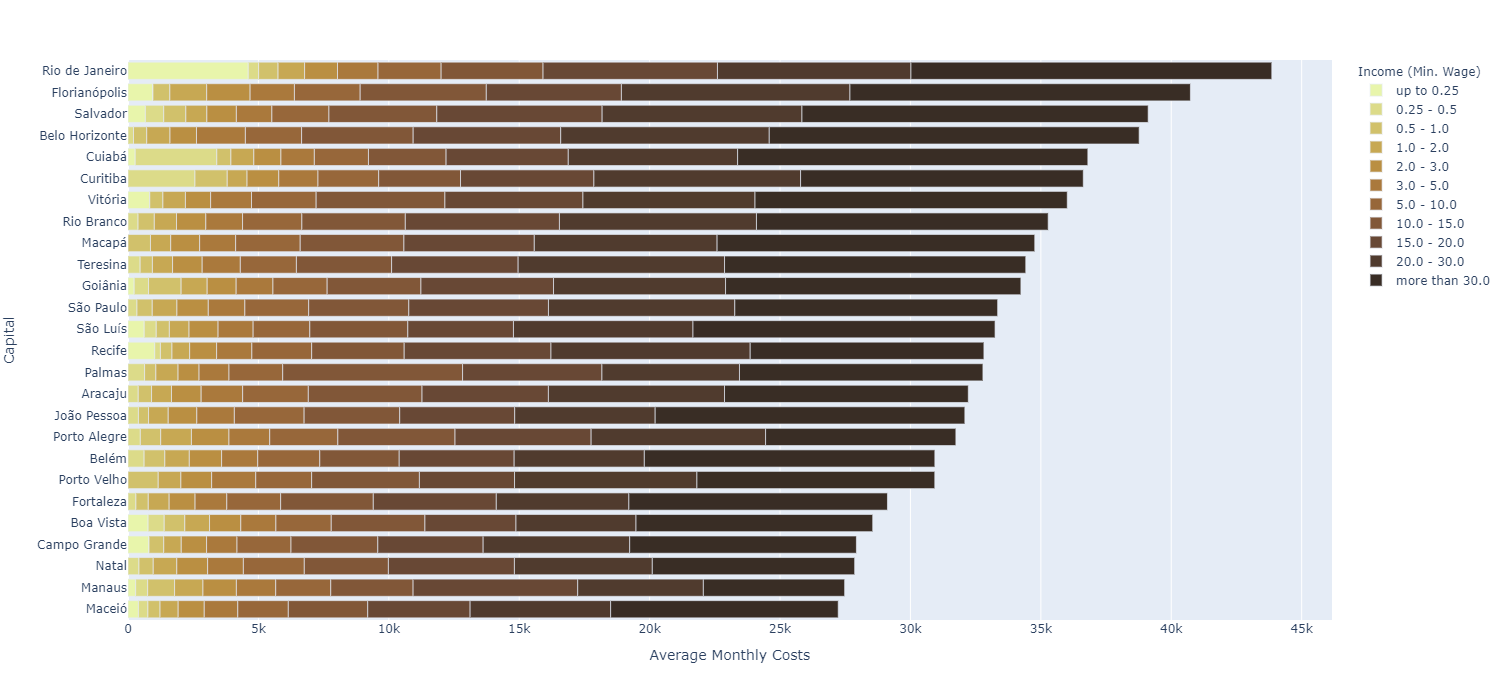

In [119]:
fig_cost_bar = px.bar(
    data_frame=df_costs
    , x='Average Monthly Costs'
    , y='Capital'
    , color='Income (Min. Wage)'
    , color_discrete_sequence=px.colors.sequential.turbid
    , height=700
    , orientation='h'
#    , facet_col='Income (Min. Wage)'
#    , facet_col_wrap=4
)
fig_cost_bar.update_layout(yaxis={'categoryorder':"sum ascending"})

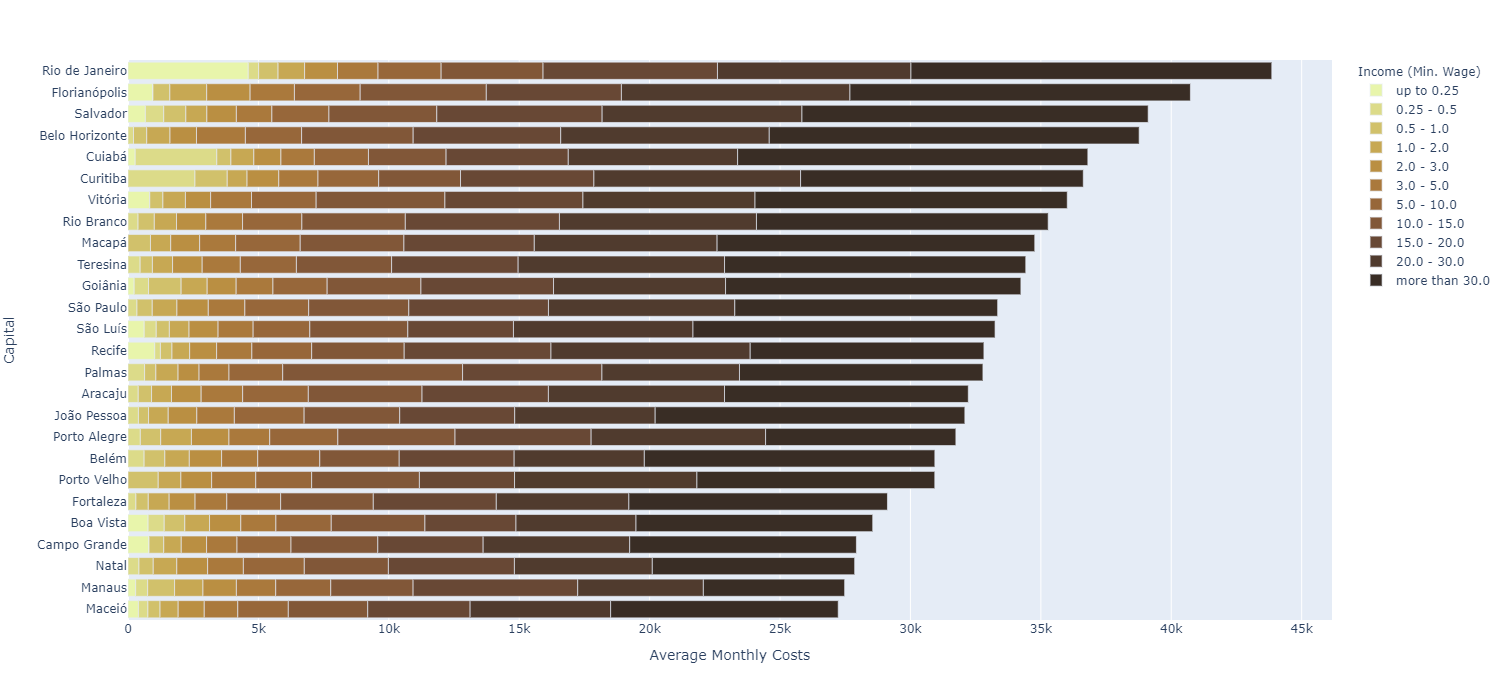

In [120]:
fig_cost_bar = px.bar(
    data_frame=df_costs
    , x='Average Monthly Costs'
    , y='Capital'
    , color='Income (Min. Wage)'
    , color_discrete_sequence=px.colors.sequential.turbid
    , height=700
    , orientation='h'
#    , facet_col='Income (Min. Wage)'
#    , facet_col_wrap=4
)
fig_cost_bar.update_layout(yaxis={'categoryorder':"sum ascending"})

## Corrigindo os valores de renda com base nos custos metropolitanos para as pessoas

In [164]:
df_income_70_00 = pd.read_csv('../data/economy/income/total_income_ipea_1970_2000.csv', sep=';')

In [165]:
df_income_70_00.iloc[:,2:] = df_income_70_00.iloc[:,2:].fillna(0)

In [166]:
# correcting data, considering it was 1,25% less then IBGE's in 2000 (multiplying for 1000, considering they simplified the currency)
df_income_70_00.iloc[:,2:] = df_income_70_00.iloc[:,2:] * 1.01248 * 1000

In [167]:
# deflating values from july/2000 to december/2018 (IPCA)
df_income_70_00.iloc[:,2:] = (df_income_70_00.iloc[:,2:] * 3.15907400).astype(np.int64)

In [168]:
def load_income_91_00(year=1991):
    df = pd.read_csv(
        f'../data/economy/income/income all sources {year} census bme.csv'
        , sep=';'
        , encoding='ANSI'
        , decimal=','
        , thousands='.'
    )

    df.drop(
        labels= [
            'Código do Nível Geográfico'
            , 'Nível Geográfico'
            , 'Item Geográfico'
            , 'Código do Item Temporal'
            , 'Nível Temporal'
            , 'Ordem Geográfica'
            , 'Freqüência'
            , 'Observações']
        , axis=1
        , inplace=True
    )
    
    df.columns = ['Cod', 'Year', 'GrossIncome']
    
    return df

In [169]:
df_income_2010 = load_income_91_00(year=2010)

In [170]:
# correção dos valores de julho de 2000 e julho de 2010 para 31 de dezembro de 2018
df_income_2010['GrossIncome'] = (df_income_2010.GrossIncome * 1.63968750).astype(np.int64)

In [171]:
df_income_70_10 = df_income_70_00.merge(
    right=df_income_2010.rename(columns={'GrossIncome': '2010'}).drop(labels='Year', axis=1)
    ,on='Cod'
    ,how='left' 
)

In [172]:
df_income_70_10['2010'] = df_income_70_10['2010'].fillna(0).astype(np.int64)

In [173]:
df_income_70_10 = df_territory.merge(
    right=df_income_70_10
    , on='Cod'
    , how='left'
)

In [174]:
df_income_70_10.rename(columns={'Territory': 'Metropolitan Area'}, inplace=True)

In [175]:
df_income_70_10 = df_income_70_10[~df_income_70_10['Metropolitan Area'].str.startswith('Demais')]

In [176]:
df_income_70_10 = df_income_70_10.drop(labels=['Cod', 'Município'], axis=1).melt(id_vars=['Metropolitan Area'], var_name='Year', value_name='Income')

In [177]:
df_income_70_10 = df_income_70_10.groupby(
    by=['Metropolitan Area', 'Year']
    , as_index=False
).sum()

In [178]:
df_income_70_10['Year'] = df_income_70_10['Year'].astype(np.int32)

In [179]:
df_income_70_10_percapita = df_income_70_10.merge(
    right=df_pop
    , left_on=['Metropolitan Area', 'Year']
    , right_on=['Metropolitan Area', 'Year']
    , how='left'
)

In [180]:
df_income_70_10_percapita['Montly Per Capita Income'] = (df_income_70_10_percapita['Income'] / df_income_70_10_percapita['Pop']).astype(np.int64)

In [181]:
df_deflactors = pd.read_csv('../data/economy/consumption/regional deflation index/metropolitan_deflation_index.csv', sep=';', decimal=',')

In [182]:
df_deflactors = df_deflactors.melt(id_vars='Metropolitan Area', var_name='Year', value_name='Deflator')

In [183]:
df_deflactors['Year'] = df_deflactors['Year'].astype(np.int32)

In [184]:
df_income_70_10_corrected = df_income_70_10_percapita.merge(
    right=df_deflactors
    , how='left'
    , left_on=['Metropolitan Area', 'Year']
    , right_on=['Metropolitan Area', 'Year']
)

In [187]:
df_income_70_10_corrected['Deflator'] = df_income_70_10_corrected['Deflator'].fillna(1)

In [188]:
df_income_70_10_corrected['Per Capita Income'] = df_income_70_10_corrected['Montly Per Capita Income'] * 12

In [202]:
df_income_70_10_corrected['Deflated Per Capita Income'] = (df_income_70_10_corrected['Per Capita Income'] / df_income_70_10_corrected['Deflator']).astype(np.int32)

In [203]:
df_income_70_10_corrected

Metropolitan Area  Year      Income      Pop  Montly Per Capita Income  \
0     Belo Horizonte  1970   672036670  1646553                       408   
1     Belo Horizonte  1980  2393049957  2590888                       923   
2     Belo Horizonte  1991  2534996154  3409027                       743   
3     Belo Horizonte  2000  5339440289  4235210                      1260   
4     Belo Horizonte  2010  8246755809  4744706                      1738   
..               ...   ...         ...      ...                       ...   
70           Vitória  1970   123989820   394168                       314   
71           Vitória  1980   544515707   715459                       761   
72           Vitória  1991   680016928  1075123                       632   
73           Vitória  2000  1593693824  1350196                      1180   
74           Vitória  2010  2645103646  1582418                      1671   

    Deflator  Per Capita Income  Deflated Per Capita Income  
0       1.00               4896                        4896  
1       0.94              11076                       11757  
2       0.95               8916                        9375  
3       0.91              15120                       16615  
4       0.97              20856                       21501  
..       ...                ...                         ...  
70      1.00               3768                        3768  
71      1.00               9132                        9132  
72      1.00               7584                        7584  
73      1.00              14160                       14160  
74      1.00              20052                       20052  

[75 rows x 8 columns]

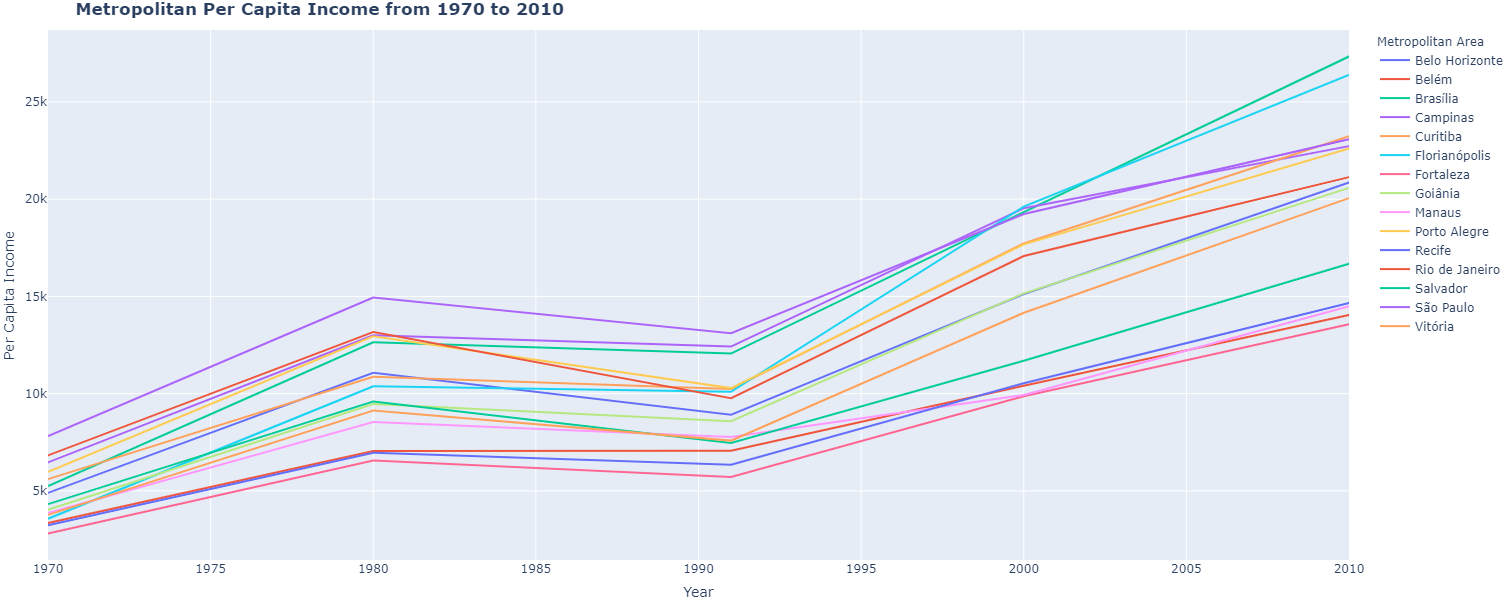

In [204]:
fig_percap_income = px.line(
    data_frame=df_income_70_10_corrected
    , x='Year'
    , y='Per Capita Income'
    , color='Metropolitan Area'
#    , log_y=True
    , title = '<b>Metropolitan Per Capita Income from 1970 to 2010<b>'
    , height=600 
    , width = 1380
)
fig_percap_income.update_layout(margin=dict(l=0, r=0, b=0, t=30))

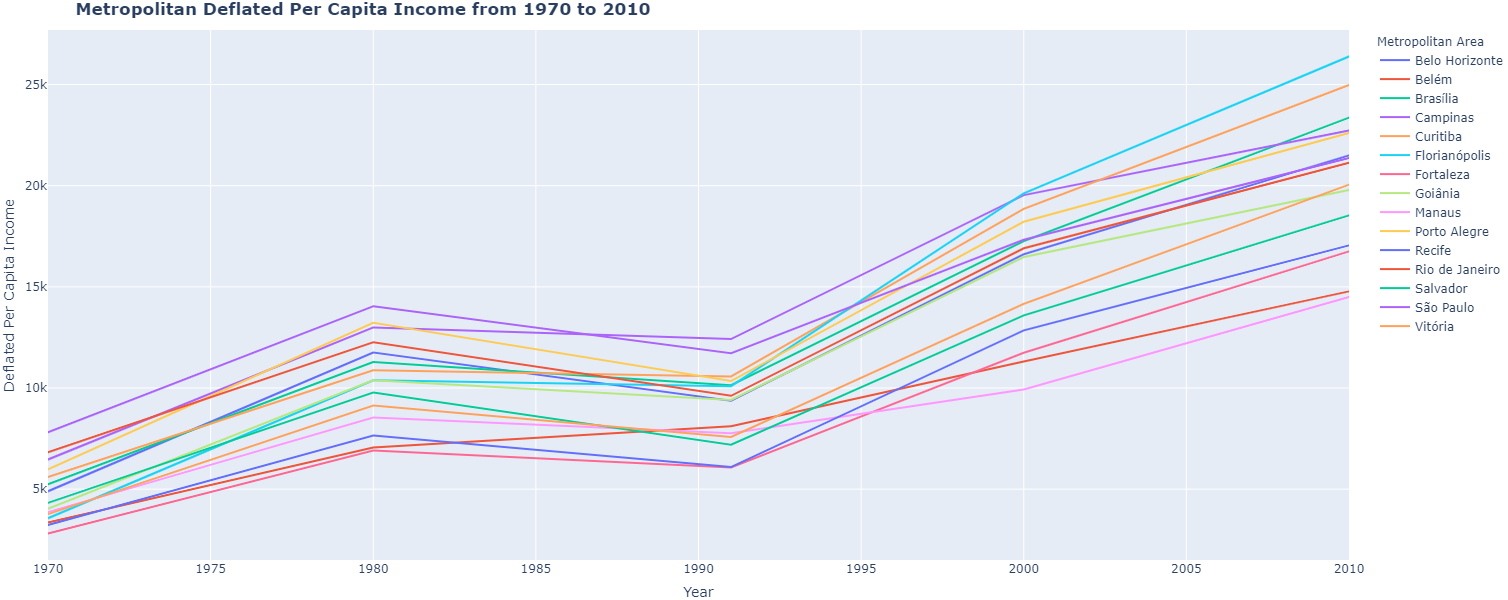

In [224]:
fig_percap_income_corrected = px.line(
    data_frame=df_income_70_10_corrected
    , x='Year'
    , y='Deflated Per Capita Income'
    , color='Metropolitan Area'
#    , log_y=True
    , title = '<b>Metropolitan Deflated Per Capita Income from 1970 to 2010<b>'
    , height=600 
    , width = 1380
)
fig_percap_income_corrected.update_layout(margin=dict(l=0, r=0, b=0, t=30))

In [226]:
pio.write_json(fig_percap_income_corrected, '../data/economy/income/fig_line_per_capita_income.json')  

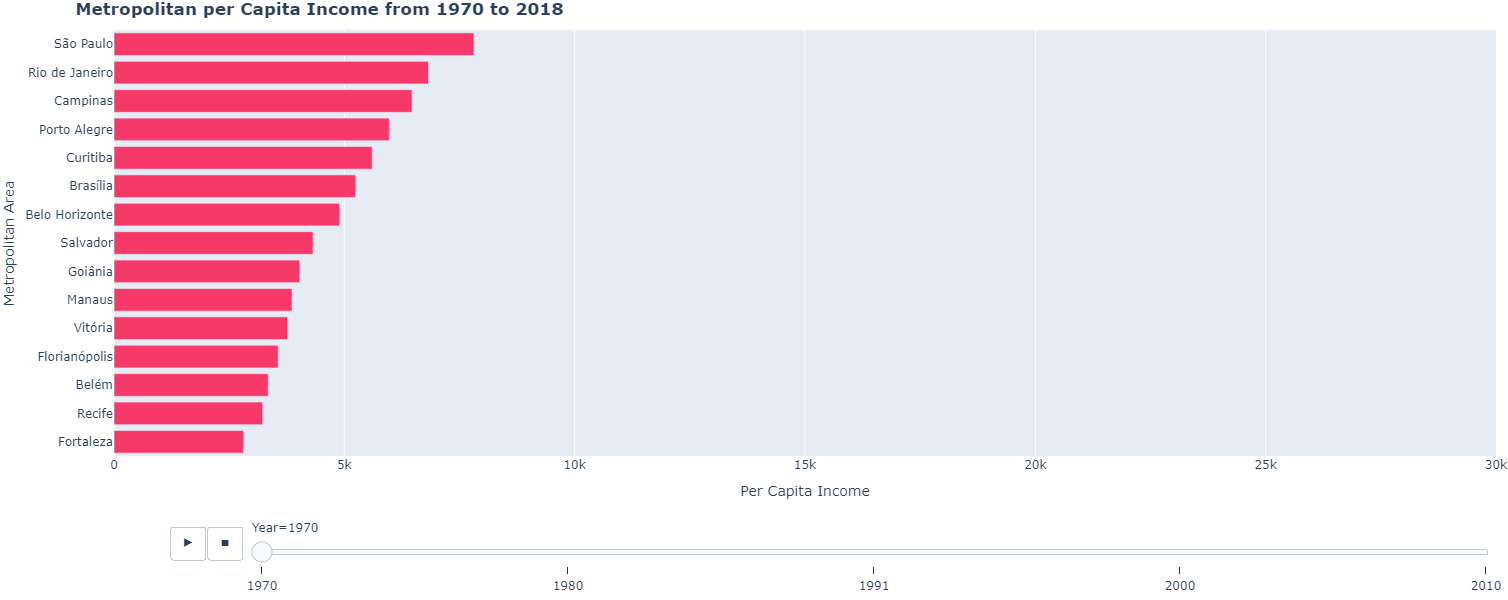

In [223]:
fig_income_percapita = px.bar(
#    data_frame=df_gdp_70_18[df_gdp_70_18.Year > 1996]
    data_frame=df_income_70_10_corrected    
    , y='Metropolitan Area'
    , x='Per Capita Income'
    , animation_frame='Year'
    , orientation='h'
    , range_x = [0, 3.0e4]
    , title = '<b>Metropolitan per Capita Income from 1970 to 2018<b>'
    , height=600 
    , width = 1380
    , color_discrete_sequence=['#F63969']
#    , hover_name='Metropolitan Area'
#    , hover_data=['Year', 'Pop']
)
fig_income_percapita.update_layout(yaxis={'categoryorder':"sum ascending"})
fig_income_percapita.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000 
fig_income_percapita.update_layout(margin=dict(l=0, r=0, b=0, t=30))

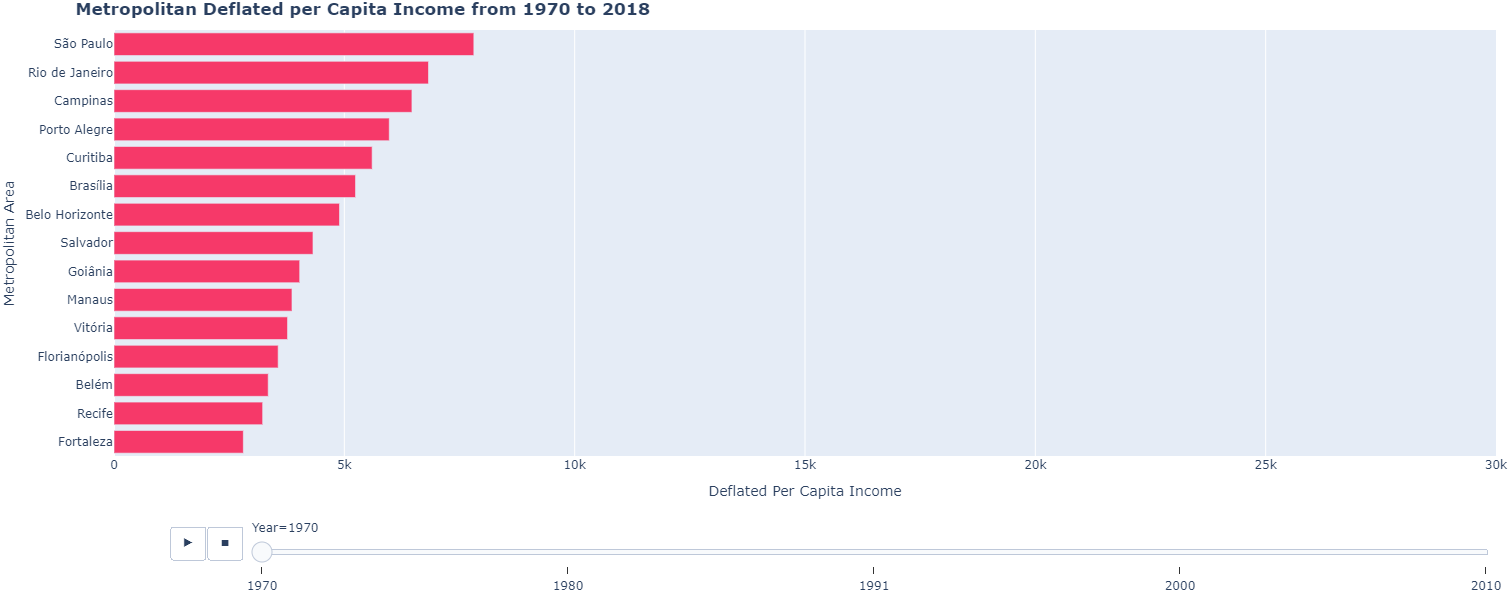

In [221]:
fig_deflated_income_percapita = px.bar(
#    data_frame=df_gdp_70_18[df_gdp_70_18.Year > 1996]
    data_frame=df_income_70_10_corrected    
    , y='Metropolitan Area'
    , x='Deflated Per Capita Income'
    , animation_frame='Year'
    , orientation='h'
    , range_x = [0, 3.0e4]
    , title = '<b>Metropolitan Deflated per Capita Income from 1970 to 2018<b>'
    , height=600 
    , width = 1380
    , color_discrete_sequence=['#F63969']
#    , hover_name='Metropolitan Area'
#    , hover_data=['Year', 'Pop']
)
fig_deflated_income_percapita.update_layout(yaxis={'categoryorder':"sum ascending"})
fig_deflated_income_percapita.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000 
fig_deflated_income_percapita.update_layout(margin=dict(l=0, r=0, b=0, t=30))

In [222]:
pio.write_json(fig_income_percapita, '../data/economy/income/fig_dynamic_bar_percapita_income.json')
pio.write_json(fig_deflated_income_percapita, '../data/economy/income/fig_dynamic_bar_deflated_percapita_income.json')